In [3]:
%matplotlib inline
import matplotlib.pylab as plt

from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import pandas as pd
import numpy as np


hrs=3
candlestick_frame = 4*hrs
pnl_threshold = 3
df = pd.read_csv('../../data/BTCUSDT.csv')

ts = list(df['time'])
open = list(df['open'])
high = list(df['high'])
low = list(df['low'])
close = list(df['close'])
volume = list(df['volume'])
tot = len(ts)
long_runup_lst = []
long_drawdown_lst = []
short_runup_lst = []
short_drawdown_lst = []

for idx in range(tot):
    if (idx >= candlestick_frame) and (idx <= tot - candlestick_frame):
        max_high = max(open[idx+1:idx+candlestick_frame])
        min_low = min(open[idx+1:idx+candlestick_frame])
        entry_price = open[idx+1]
        long_runup_lst.append(round((max_high*100/entry_price)-100, 6))
        long_drawdown_lst.append(round((min_low*100/entry_price)-100, 6))
        short_runup_lst.append(round((entry_price*100/min_low)-100, 6))
        short_drawdown_lst.append(round((entry_price*100/max_high)-100, 6))
    else:
        long_runup_lst.append(0)
        long_drawdown_lst.append(0)
        short_runup_lst.append(0)
        short_drawdown_lst.append(0)     


long=[]
short=[]
dont_trade=[]
signal = []

for idx in range(tot):
    if (idx >= candlestick_frame) and (idx <= tot - candlestick_frame):
        if long_runup_lst[idx] >= pnl_threshold:
            signal.append(1)
        elif short_runup_lst[idx] >= pnl_threshold:
            signal.append(2)
        else:
            signal.append(0)
    else:
        signal.append(0)


pc = [0] + [round((open[i]*100/open[(i-1)])-100, 4) for i in range(1,len(open), 1)]
df = pd.DataFrame()
df['0'] = pc
y = pd.Series( (i for i in signal) )

In [2]:
df.to_csv('../../data/df.csv', index=False)
y.to_csv('../../data/y.csv', index=False)

In [2]:
df["id"] = df.index
df = df.melt(id_vars="id", var_name="time").sort_values(["id", "time"]).reset_index(drop=True)

In [3]:
df.head()


,id,time,value
0,0,0,0.0
1,1,0,0.0
2,2,0,0.0
3,3,0,0.0
4,4,0,0.0


In [5]:
# X = extract_features(df[df["id"] < len(df)], column_id="id", column_sort="time", impute_function=impute)
X = pd.read_csv('../../data/X.csv')
X.head()


,value__variance_larger_than_standard_deviation,value__has_duplicate_max,value__has_duplicate_min,value__has_duplicate,value__sum_values,value__abs_energy,value__mean_abs_change,value__mean_change,value__mean_second_derivative_central,value__median,...,value__fourier_entropy__bins_5,value__fourier_entropy__bins_10,value__fourier_entropy__bins_100,value__permutation_entropy__dimension_3__tau_1,value__permutation_entropy__dimension_4__tau_1,value__permutation_entropy__dimension_5__tau_1,value__permutation_entropy__dimension_6__tau_1,value__permutation_entropy__dimension_7__tau_1,value__query_similarity_count__query_None__threshold_0.0,value__mean_n_absolute_max__number_of_maxima_7
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [7]:
relevant_features = set()

for label in y.unique():
    y_train_binary = y_train == label
    X_train_filtered = select_features(X_train, y_train_binary)
    print("Number of relevant features for class {}: {}/{}".format(label, X_train_filtered.shape[1], X_train.shape[1]))
    relevant_features = relevant_features.union(set(X_train_filtered.columns))

Number of relevant features for class 0: 24/783
Number of relevant features for class 1: 5/783
Number of relevant features for class 2: 29/783


In [8]:
len(relevant_features)


29

In [10]:
X_train_filtered = X_train[list(relevant_features)]
X_test_filtered = X_test[list(relevant_features)]

In [12]:
X_train_filtered

,value__range_count__max_1__min_-1,"value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)",value__quantile__q_0.8,value__sum_values,value__quantile__q_0.6,value__count_above__t_0,"value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)",value__quantile__q_0.9,value__quantile__q_0.4,value__mean,...,value__absolute_maximum,value__quantile__q_0.1,value__quantile__q_0.2,"value__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)","value__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)",value__quantile__q_0.3,value__quantile__q_0.7,"value__fft_coefficient__attr_""real""__coeff_0",value__count_below__t_0,value__minimum
2389,1.0,-0.056495,-0.2913,-0.2913,-0.2913,0.0,-0.079896,-0.2913,-0.2913,-0.2913,...,0.2913,-0.2913,-0.2913,-0.178652,-0.112989,-0.2913,-0.2913,-0.2913,1.0,-0.2913
3404,1.0,0.011792,0.0608,0.0608,0.0608,1.0,0.016676,0.0608,0.0608,0.0608,...,0.0608,0.0608,0.0608,0.037288,0.023583,0.0608,0.0608,0.0608,0.0,0.0608
77162,1.0,0.033842,0.1745,0.1745,0.1745,1.0,0.047861,0.1745,0.1745,0.1745,...,0.1745,0.1745,0.1745,0.107019,0.067685,0.1745,0.1745,0.1745,0.0,0.1745
18427,1.0,-0.127496,-0.6574,-0.6574,-0.6574,0.0,-0.180307,-0.6574,-0.6574,-0.6574,...,0.6574,-0.6574,-0.6574,-0.403178,-0.254992,-0.6574,-0.6574,-0.6574,1.0,-0.6574
27603,1.0,0.014429,0.0744,0.0744,0.0744,1.0,0.020406,0.0744,0.0744,0.0744,...,0.0744,0.0744,0.0744,0.045629,0.028858,0.0744,0.0744,0.0744,0.0,0.0744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40960,1.0,-0.018987,-0.0979,-0.0979,-0.0979,0.0,-0.026851,-0.0979,-0.0979,-0.0979,...,0.0979,-0.0979,-0.0979,-0.060041,-0.037973,-0.0979,-0.0979,-0.0979,1.0,-0.0979
37989,1.0,0.005469,0.0282,0.0282,0.0282,1.0,0.007734,0.0282,0.0282,0.0282,...,0.0282,0.0282,0.0282,0.017295,0.010938,0.0282,0.0282,0.0282,0.0,0.0282
26590,0.0,-0.718431,-3.7044,-3.7044,-3.7044,0.0,-1.016014,-3.7044,-3.7044,-3.7044,...,3.7044,-3.7044,-3.7044,-2.271877,-1.436861,-3.7044,-3.7044,-3.7044,1.0,-3.7044
35322,1.0,0.068519,0.3533,0.3533,0.3533,1.0,0.096900,0.3533,0.3533,0.3533,...,0.3533,0.3533,0.3533,0.216676,0.137038,0.3533,0.3533,0.3533,0.0,0.3533


In [13]:
len(y) == (len(X_train_filtered) + len(X_test_filtered))

True

In [14]:
dfs = [X_train_filtered, X_test_filtered]
concatenated_df = pd.concat(dfs, ignore_index=True)  # Set ignore_index=True to reset index
concatenated_df['signal'] = y
pd.DataFrame(concatenated_df).to_csv(f'../../data/training_dataset_pc_tsfresh.csv', index=False)


In [15]:
concatenated_df

,value__range_count__max_1__min_-1,"value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)",value__quantile__q_0.8,value__sum_values,value__quantile__q_0.6,value__count_above__t_0,"value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)",value__quantile__q_0.9,value__quantile__q_0.4,value__mean,...,value__quantile__q_0.1,value__quantile__q_0.2,"value__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)","value__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)",value__quantile__q_0.3,value__quantile__q_0.7,"value__fft_coefficient__attr_""real""__coeff_0",value__count_below__t_0,value__minimum,signal
0,1.0,-0.056495,-0.2913,-0.2913,-0.2913,0.0,-0.079896,-0.2913,-0.2913,-0.2913,...,-0.2913,-0.2913,-0.178652,-0.112989,-0.2913,-0.2913,-0.2913,1.0,-0.2913,0
1,1.0,0.011792,0.0608,0.0608,0.0608,1.0,0.016676,0.0608,0.0608,0.0608,...,0.0608,0.0608,0.037288,0.023583,0.0608,0.0608,0.0608,0.0,0.0608,0
2,1.0,0.033842,0.1745,0.1745,0.1745,1.0,0.047861,0.1745,0.1745,0.1745,...,0.1745,0.1745,0.107019,0.067685,0.1745,0.1745,0.1745,0.0,0.1745,0
3,1.0,-0.127496,-0.6574,-0.6574,-0.6574,0.0,-0.180307,-0.6574,-0.6574,-0.6574,...,-0.6574,-0.6574,-0.403178,-0.254992,-0.6574,-0.6574,-0.6574,1.0,-0.6574,0
4,1.0,0.014429,0.0744,0.0744,0.0744,1.0,0.020406,0.0744,0.0744,0.0744,...,0.0744,0.0744,0.045629,0.028858,0.0744,0.0744,0.0744,0.0,0.0744,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116166,1.0,0.035142,0.1812,0.1812,0.1812,1.0,0.049698,0.1812,0.1812,0.1812,...,0.1812,0.1812,0.111128,0.070284,0.1812,0.1812,0.1812,0.0,0.1812,0
116167,1.0,0.106744,0.5504,0.5504,0.5504,1.0,0.150959,0.5504,0.5504,0.5504,...,0.5504,0.5504,0.337556,0.213489,0.5504,0.5504,0.5504,0.0,0.5504,0
116168,1.0,0.023661,0.1220,0.1220,0.1220,1.0,0.033461,0.1220,0.1220,0.1220,...,0.1220,0.1220,0.074822,0.047321,0.1220,0.1220,0.1220,0.0,0.1220,0
116169,1.0,0.015457,0.0797,0.0797,0.0797,1.0,0.021859,0.0797,0.0797,0.0797,...,0.0797,0.0797,0.048879,0.030914,0.0797,0.0797,0.0797,0.0,0.0797,0


In [1]:
from imblearn.over_sampling import SMOTE
import pandas as pd

concatenated_df = pd.read_csv('../../data/training_dataset_pc_tsfresh.csv')


X = concatenated_df.drop('signal', axis=1)
y = concatenated_df['signal']

# Initialize SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Fit and resample the data
X_resampled, y_resampled = smote.fit_resample(X, y)


In [2]:
data = X_resampled
data['signal'] = list(y_resampled)

In [3]:
data

,value__range_count__max_1__min_-1,"value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)",value__quantile__q_0.8,value__sum_values,value__quantile__q_0.6,value__count_above__t_0,"value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)",value__quantile__q_0.9,value__quantile__q_0.4,value__mean,...,value__quantile__q_0.1,value__quantile__q_0.2,"value__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)","value__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)",value__quantile__q_0.3,value__quantile__q_0.7,"value__fft_coefficient__attr_""real""__coeff_0",value__count_below__t_0,value__minimum,signal
0,1.0,-0.056495,-0.291300,-0.291300,-0.291300,0.0,-0.079896,-0.291300,-0.291300,-0.291300,...,-0.291300,-0.291300,-0.178652,-0.112989,-0.291300,-0.291300,-0.291300,1.0,-0.291300,0
1,1.0,0.011792,0.060800,0.060800,0.060800,1.0,0.016676,0.060800,0.060800,0.060800,...,0.060800,0.060800,0.037288,0.023583,0.060800,0.060800,0.060800,0.0,0.060800,0
2,1.0,0.033842,0.174500,0.174500,0.174500,1.0,0.047861,0.174500,0.174500,0.174500,...,0.174500,0.174500,0.107019,0.067685,0.174500,0.174500,0.174500,0.0,0.174500,0
3,1.0,-0.127496,-0.657400,-0.657400,-0.657400,0.0,-0.180307,-0.657400,-0.657400,-0.657400,...,-0.657400,-0.657400,-0.403178,-0.254992,-0.657400,-0.657400,-0.657400,1.0,-0.657400,0
4,1.0,0.014429,0.074400,0.074400,0.074400,1.0,0.020406,0.074400,0.074400,0.074400,...,0.074400,0.074400,0.045629,0.028858,0.074400,0.074400,0.074400,0.0,0.074400,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331585,1.0,0.078984,0.407259,0.407259,0.407259,1.0,0.111700,0.407259,0.407259,0.407259,...,0.407259,0.407259,0.249768,0.157967,0.407259,0.407259,0.407259,0.0,0.407259,2
331586,1.0,0.063113,0.325428,0.325428,0.325428,1.0,0.089256,0.325428,0.325428,0.325428,...,0.325428,0.325428,0.199582,0.126227,0.325428,0.325428,0.325428,0.0,0.325428,2
331587,1.0,-0.108324,-0.558542,-0.558542,-0.558542,0.0,-0.153193,-0.558542,-0.558542,-0.558542,...,-0.558542,-0.558542,-0.342549,-0.216647,-0.558542,-0.558542,-0.558542,1.0,-0.558542,2
331588,1.0,0.012005,0.061900,0.061900,0.061900,1.0,0.016977,0.061900,0.061900,0.061900,...,0.061900,0.061900,0.037963,0.024010,0.061900,0.061900,0.061900,0.0,0.061900,2


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset migh

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1


[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset migh

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1


,Description,Value
0,Session id,123
1,Target,signal
2,Target type,Multiclass
3,Original data shape,"(331590, 30)"
4,Transformed data shape,"(331590, 30)"
5,Transformed train set shape,"(232112, 30)"
6,Transformed test set shape,"(99478, 30)"
7,Numeric features,29
8,Preprocess,True
9,Imputation type,simple


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset migh

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.6964,0.7793,0.6964,0.6902,0.6914,0.5446,0.5461,0.3980
et,Extra Trees Classifier,0.6955,0.8352,0.6955,0.6893,0.6907,0.5433,0.5446,25.5610
rf,Random Forest Classifier,0.6939,0.8432,0.6939,0.6879,0.6893,0.5408,0.5420,55.4980
knn,K Neighbors Classifier,0.6521,0.8301,0.6521,0.6548,0.6460,0.4781,0.4840,9.0290
xgboost,Extreme Gradient Boosting,0.4592,0.6504,0.4592,0.4579,0.4533,0.1887,0.1908,2.3990
lightgbm,Light Gradient Boosting Machine,0.4566,0.6476,0.4566,0.4553,0.4494,0.1849,0.1875,6.2550
ada,Ada Boost Classifier,0.3660,0.5403,0.3660,0.3657,0.3483,0.0489,0.0510,73.6400
lr,Logistic Regression,0.3355,0.5076,0.3355,0.3363,0.3249,0.0032,0.0033,0.5760
lda,Linear Discriminant Analysis,0.3352,0.5071,0.3352,0.3354,0.3306,0.0028,0.0028,1.6630
qda,Quadratic Discriminant Analysis,0.3350,0.5013,0.3350,0.2375,0.2206,0.0025,0.0037,1.1580


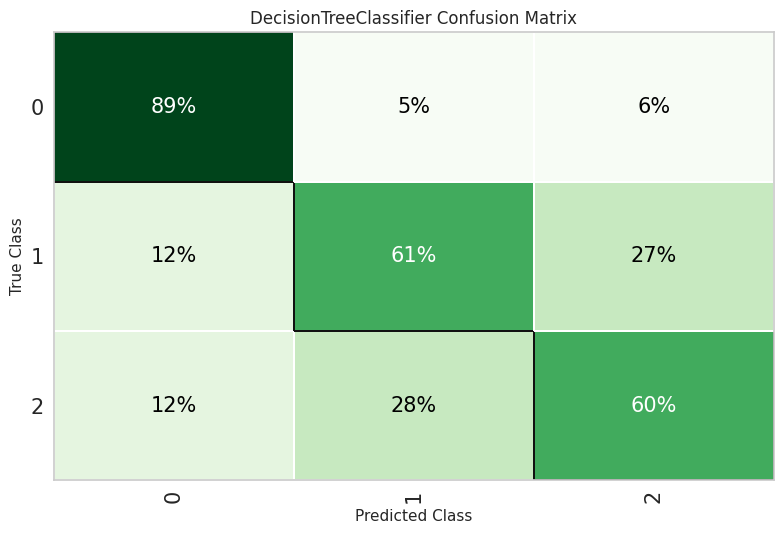

In [4]:
import pandas as pd
from pycaret.classification import *
from pycaret.classification import ClassificationExperiment
from lightgbm import LGBMClassifier
exp = ClassificationExperiment()


# data = pd.read_csv('../../data/training_dataset_pc_tsfresh.csv')

s = setup(data, target = 'signal', session_id = 123, use_gpu=True)
best = compare_models(exclude=['gbc'])
# best = create_model(LGBMClassifier())
# plot confusion matrix
plot_model(best, plot = 'confusion_matrix', plot_kwargs = {'percent': True})